In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
#sys.path.append('/content/drive/MyDrive/EcolesIngenieur/NTNU/MachineLearning/GroupWork/')
import utils
#import settings


plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
from sklearn.preprocessing import StandardScaler
import pickle #pour charger un scaler déjà entrainé

In [3]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path='')

In [4]:
def normalize_df(df, keys, time_column):
    df_normalized = df.copy()
    columns_to_drop = [ c for c in df_normalized.columns if (c not in keys) and (c != time_column) ]
    df_normalized = df_normalized.drop(columns=columns_to_drop)
    for key in keys :
        if key in time_column:
            continue
        else: 
            if df[key].std() == .0:
                columns_to_drop.append(key)
                df_normalized.drop(columns=key)
            else:
                df_normalized[key] = (df[key] - df[key].mean()) / df[key].std()
    df_normalized.drop(columns=columns_to_drop)
    return df_normalized

In [5]:
import models_arthur.signal_process as s
from datetime import datetime, timedelta

locations = ['a', 'b', 'c']
hours = [ f"0{h}" if h < 10 else str(h) for h in range(24) ]

basic_params = {
    'diff_path': ''
}
params = { 'a': {
        'location': 'a',
        'start_date': datetime(2019,6, 3, 0, 0, 0), 
        'end_date': datetime(2022, 10, 23, 0, 0, 0),
        'split_date': datetime(2022, 7, 21),
        # 'split_date': pd.to_datetime("2022-07-21"),
        **basic_params
    },
    'b': {
        'location': 'b',
        'start_date': datetime(2019, 1, 1, 0, 0, 0), 
        'end_date': datetime(2022, 5, 3, 21, 0, 0), 
        'split_date': datetime(2022, 2, 3),
        # 'split_date': pd.to_datetime("2021-12-15"),
        **basic_params
    },
    'c': {
        'location': 'c',
        'start_date': datetime(2019, 1, 1, 0, 0, 0),
        'end_date': datetime(2022, 5, 1, 21, 0, 0),
        'split_date': datetime(2022, 3, 1),
        # 'split_date': pd.to_datetime("2022-01-01"),
        **basic_params
    },
}

In [6]:
s_ = { loc: s.SignalProcess(**params[loc]) for loc in locations }
y_train = { loc: s_[loc].train_normalized for loc in locations }
y_test = { loc: s_[loc].test_normalized for loc in locations }

In [7]:
y_pred = s_['a'].get_filtered_signal_on_training_dates()
for h in hours:
    print(np.mean(y_pred[h]), np.std(y_pred[h]))

0.0 0.0
0.13170495250264003 0.3917185951775338
0.20096430840713905 0.6236475743611364
0.10668624609818404 0.6074070686530199
0.10186739418962991 0.685172670778685
0.08391733107724081 0.7048931799760879
0.04891262038160287 0.7058310294448461
0.01797608258963618 0.7167524548472102
0.00035461409768755125 0.7098436040552778
1.1497455271199033e-17 0.6786210890162131
2.2994910542398065e-17 0.6522578303120479
4.598982108479613e-17 0.6734413339487648
4.598982108479613e-17 0.6967448340351939
0.0 0.7583961334077454
0.019915772587631272 0.7904555578444417
0.04245956060848051 0.7680934279214263
0.06153787889548242 0.7302197222888998
0.07796631446105928 0.6958586741500729
0.0860528253189229 0.6543863085051121
0.24087596738779704 0.7488790791242296
0.2072105789727137 0.5867015287680873
0.04482685754048107 0.23715292674685615
0.0 0.0
0.0 0.0


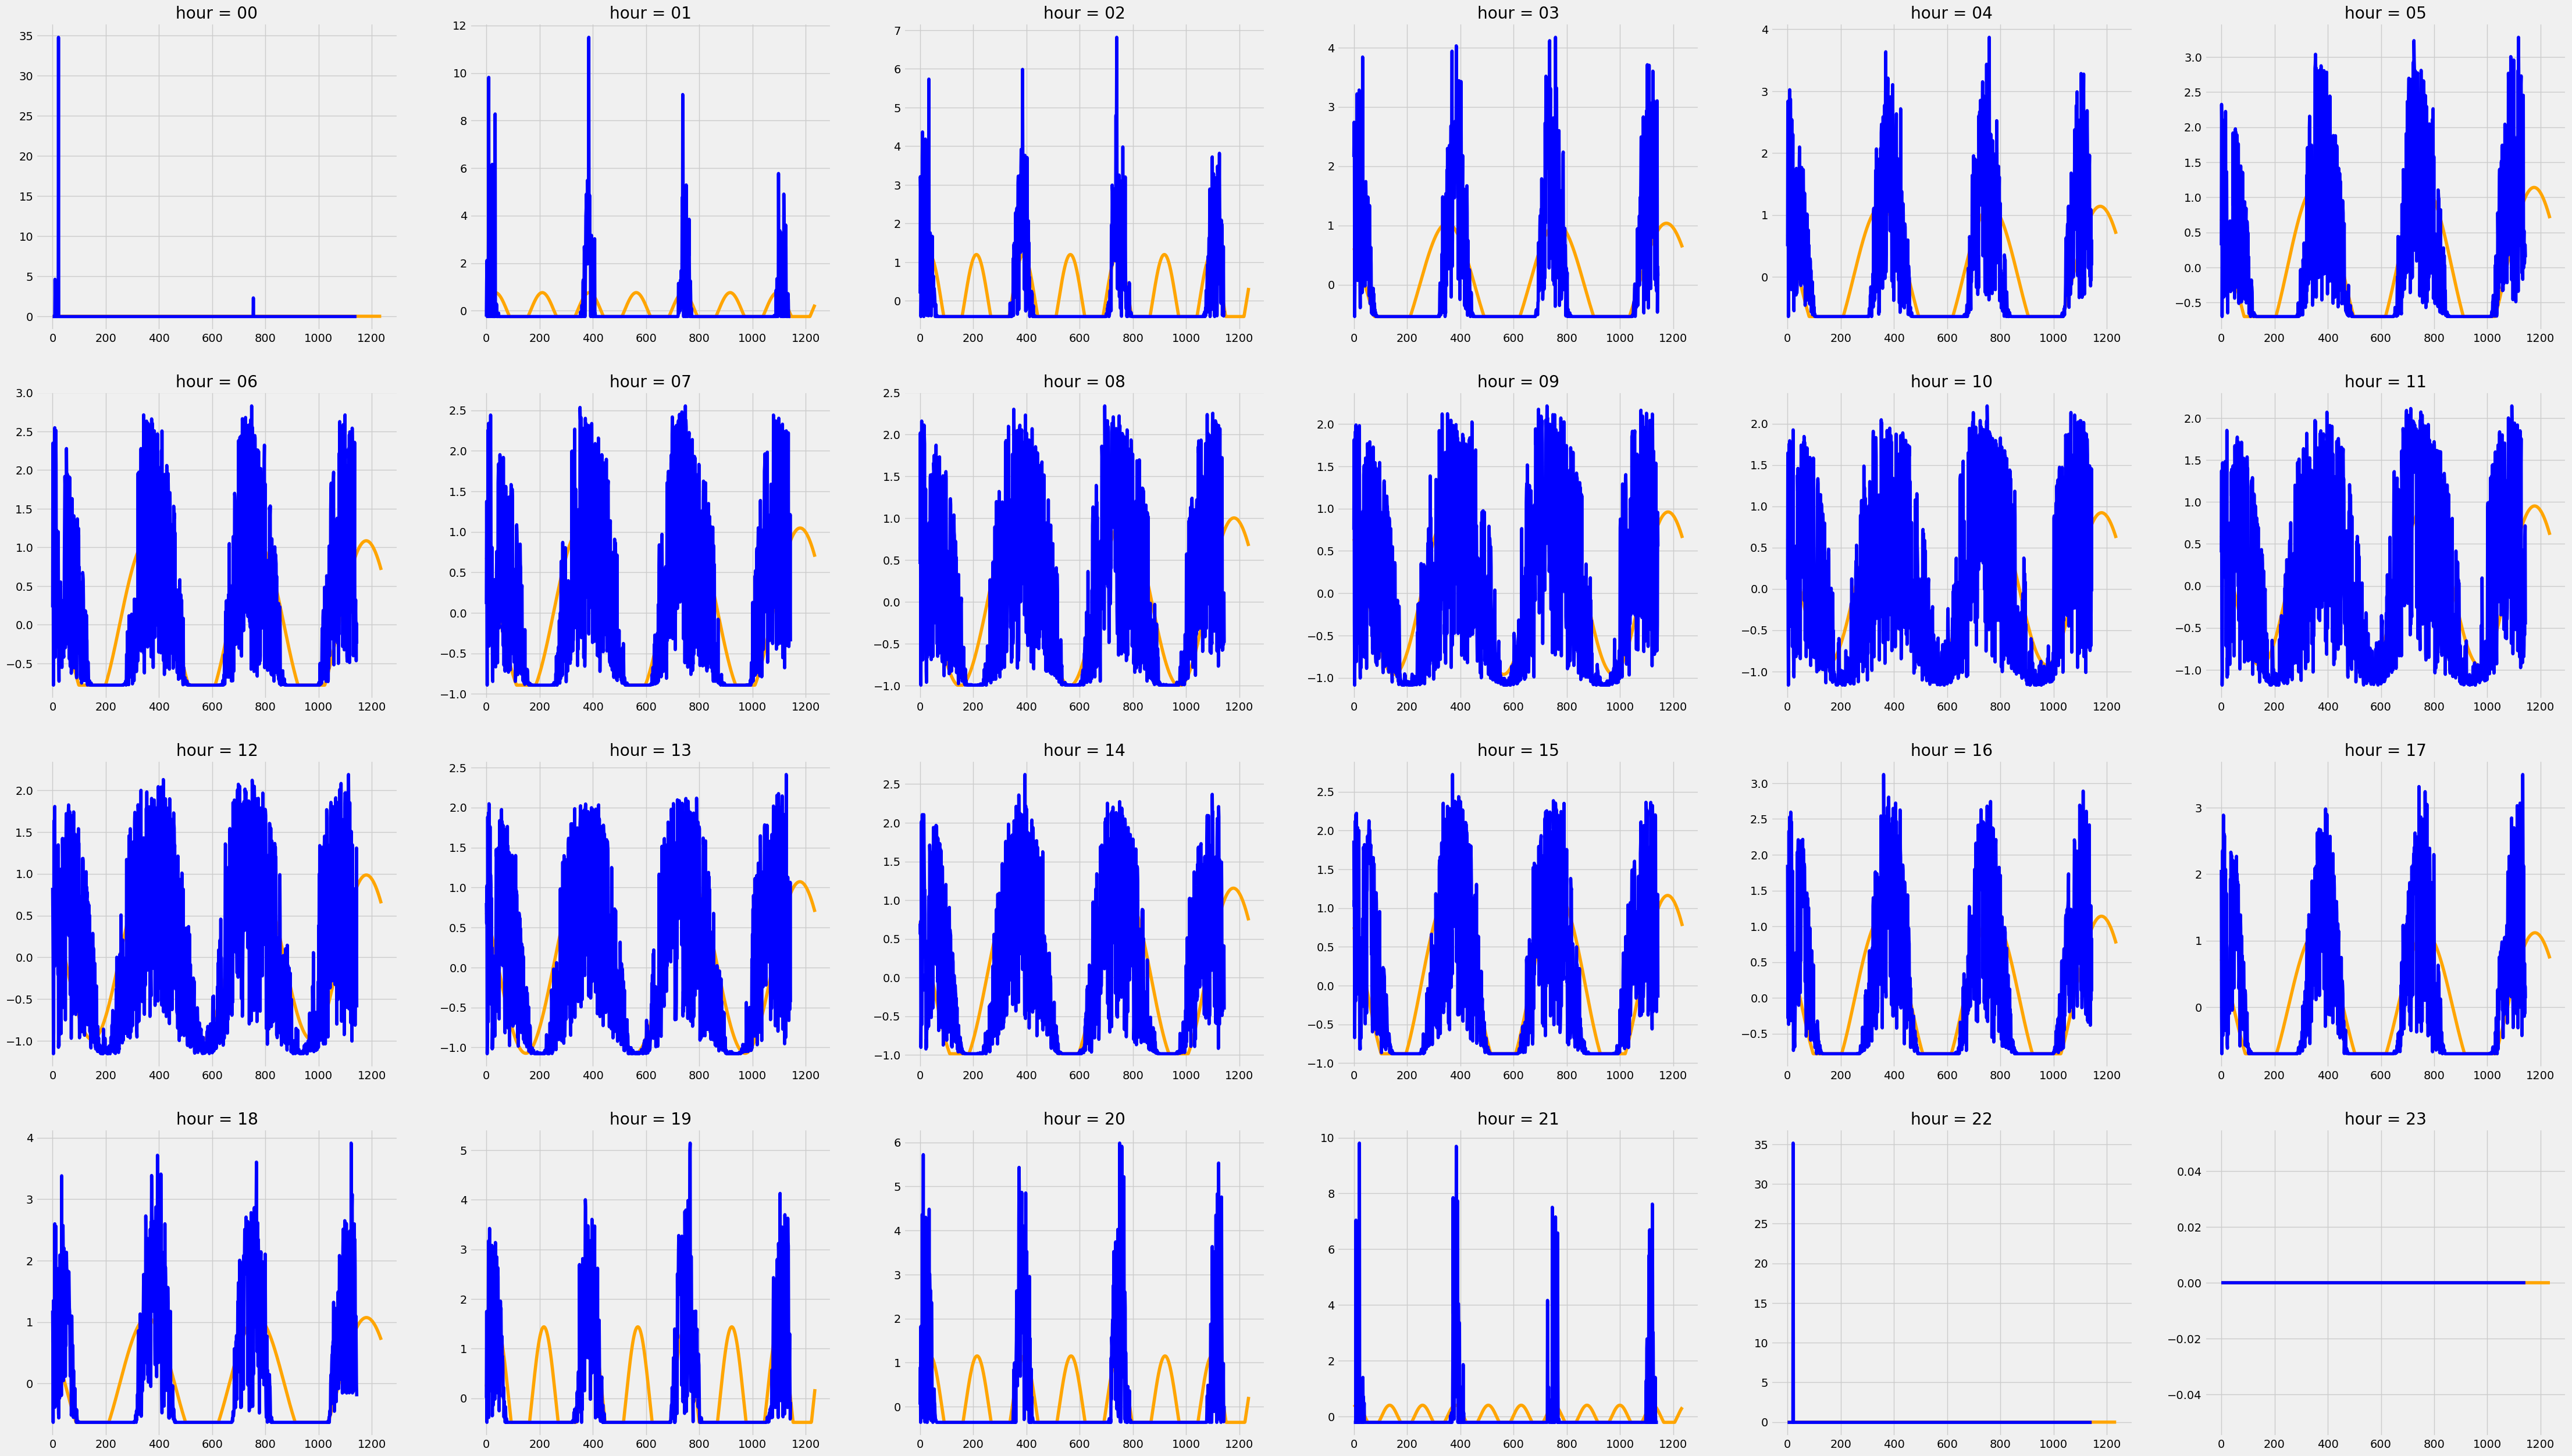

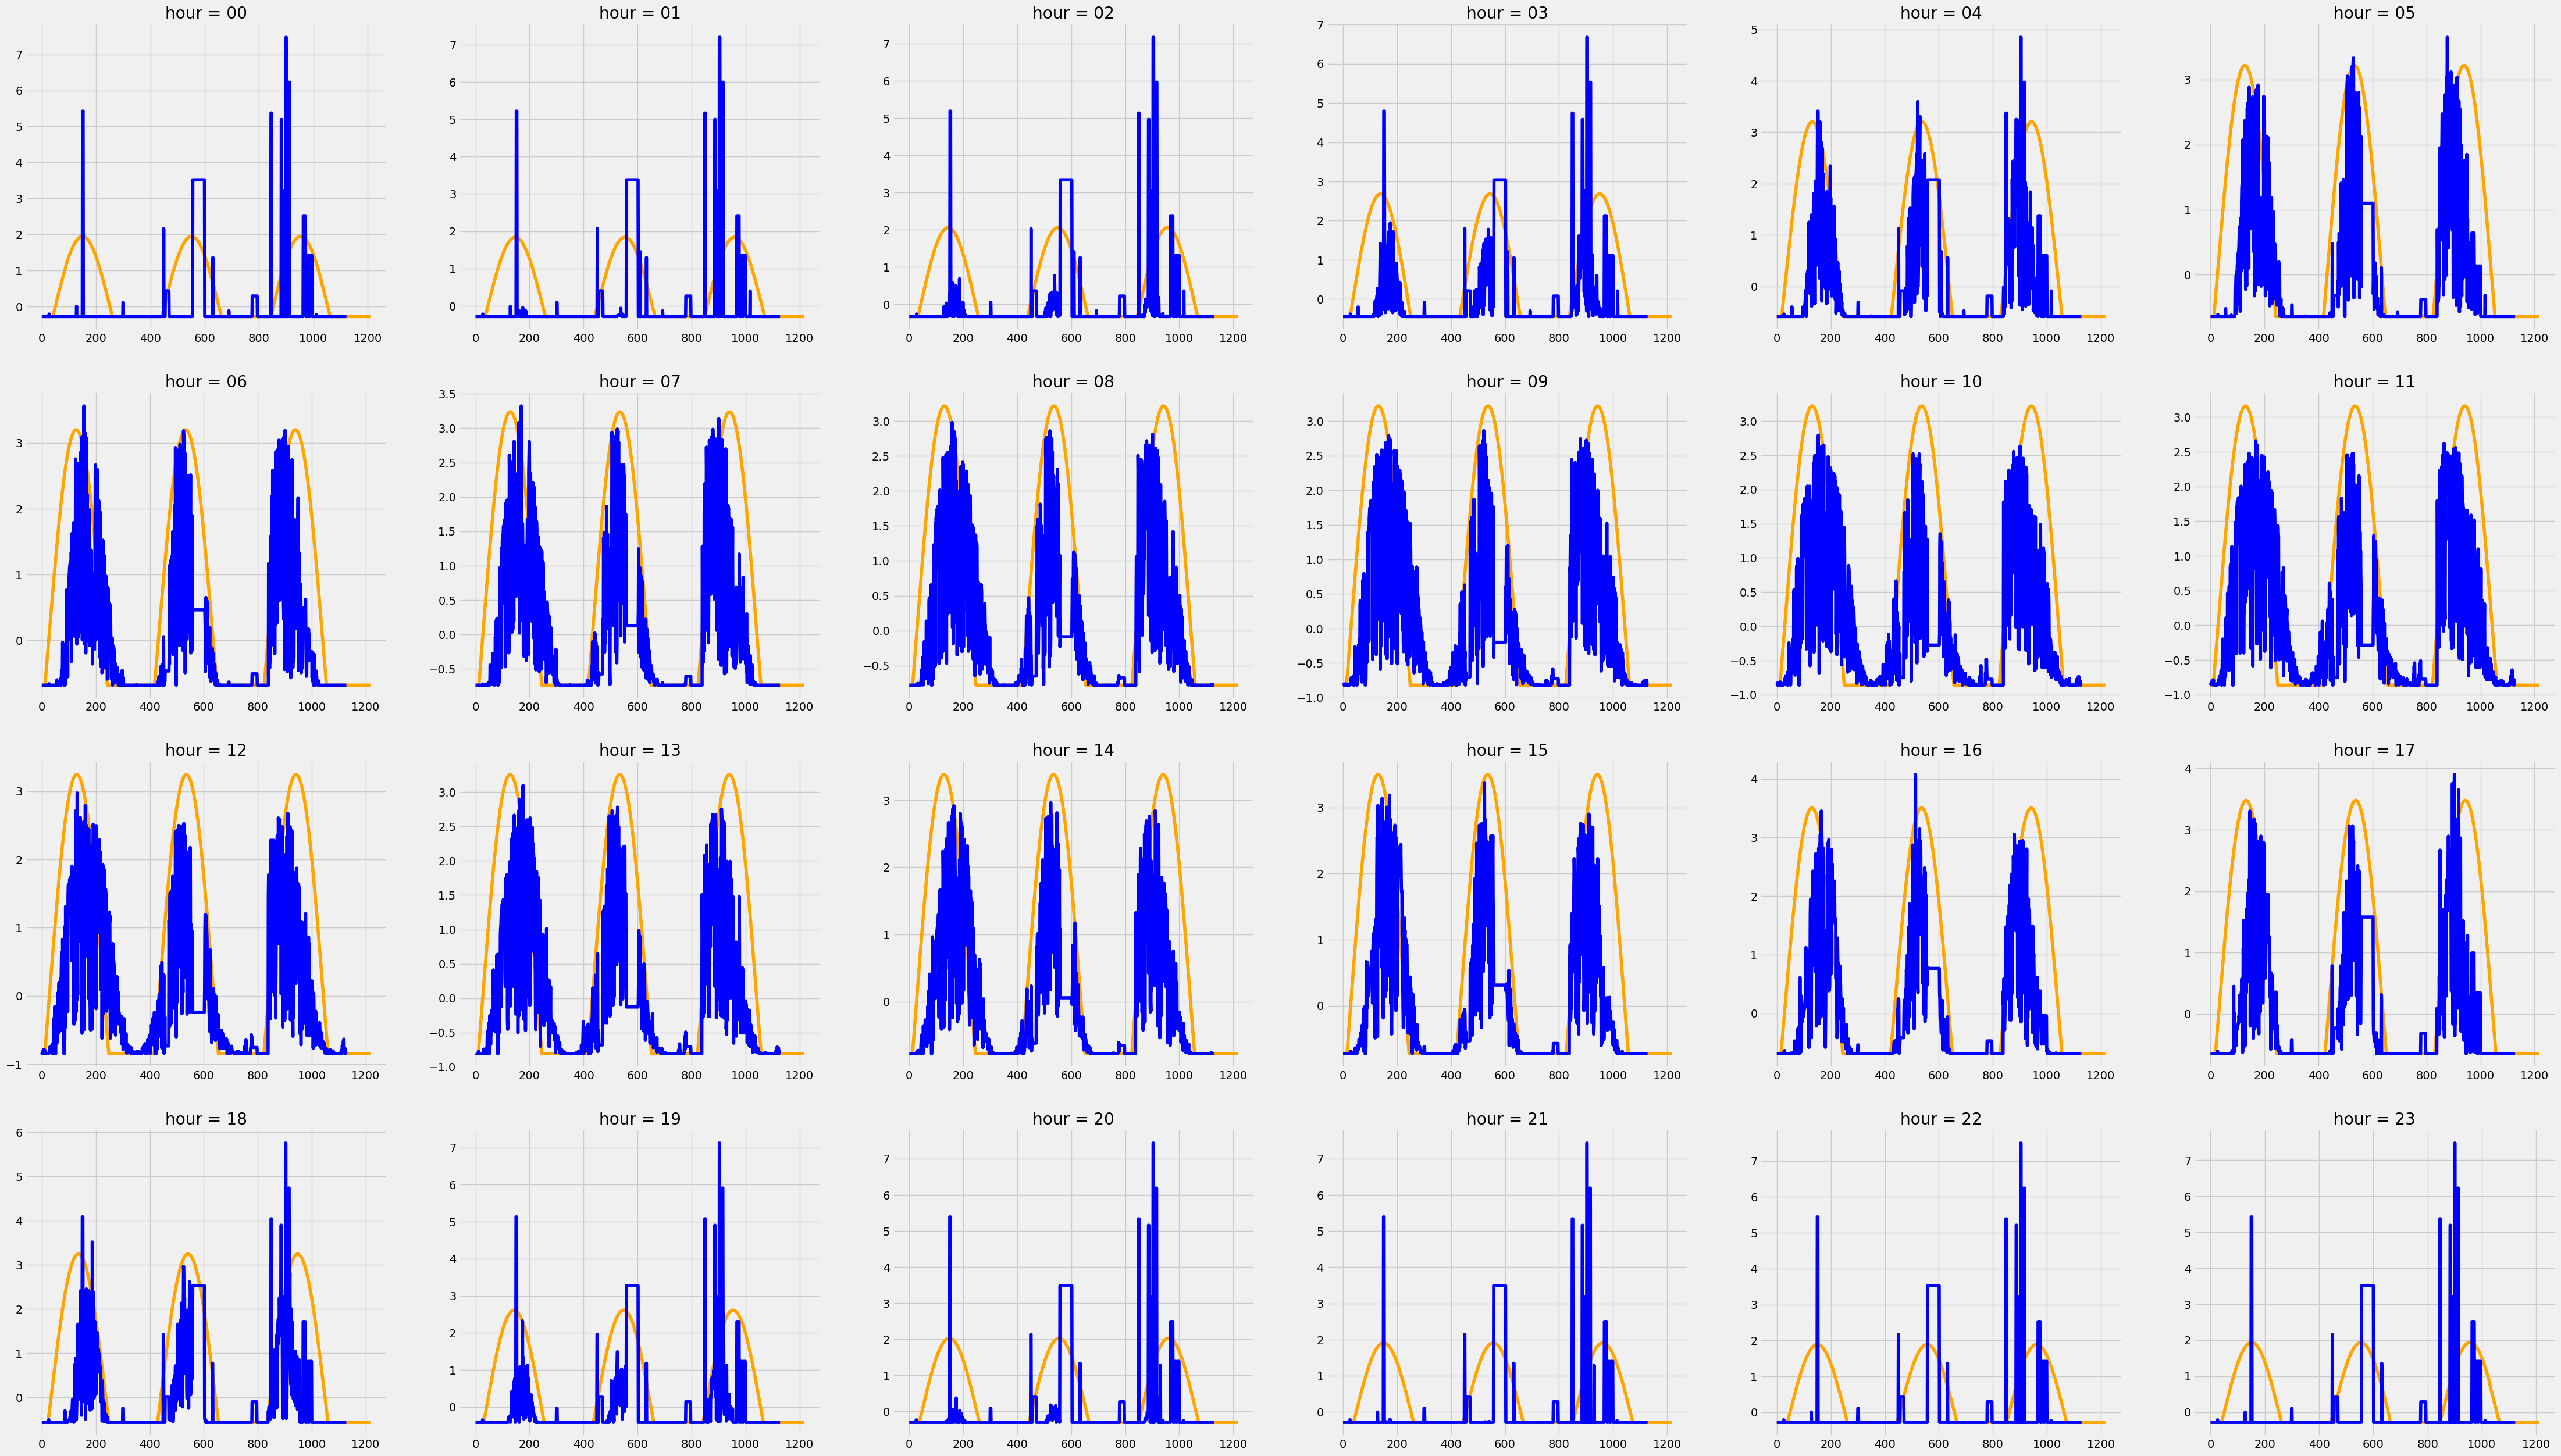

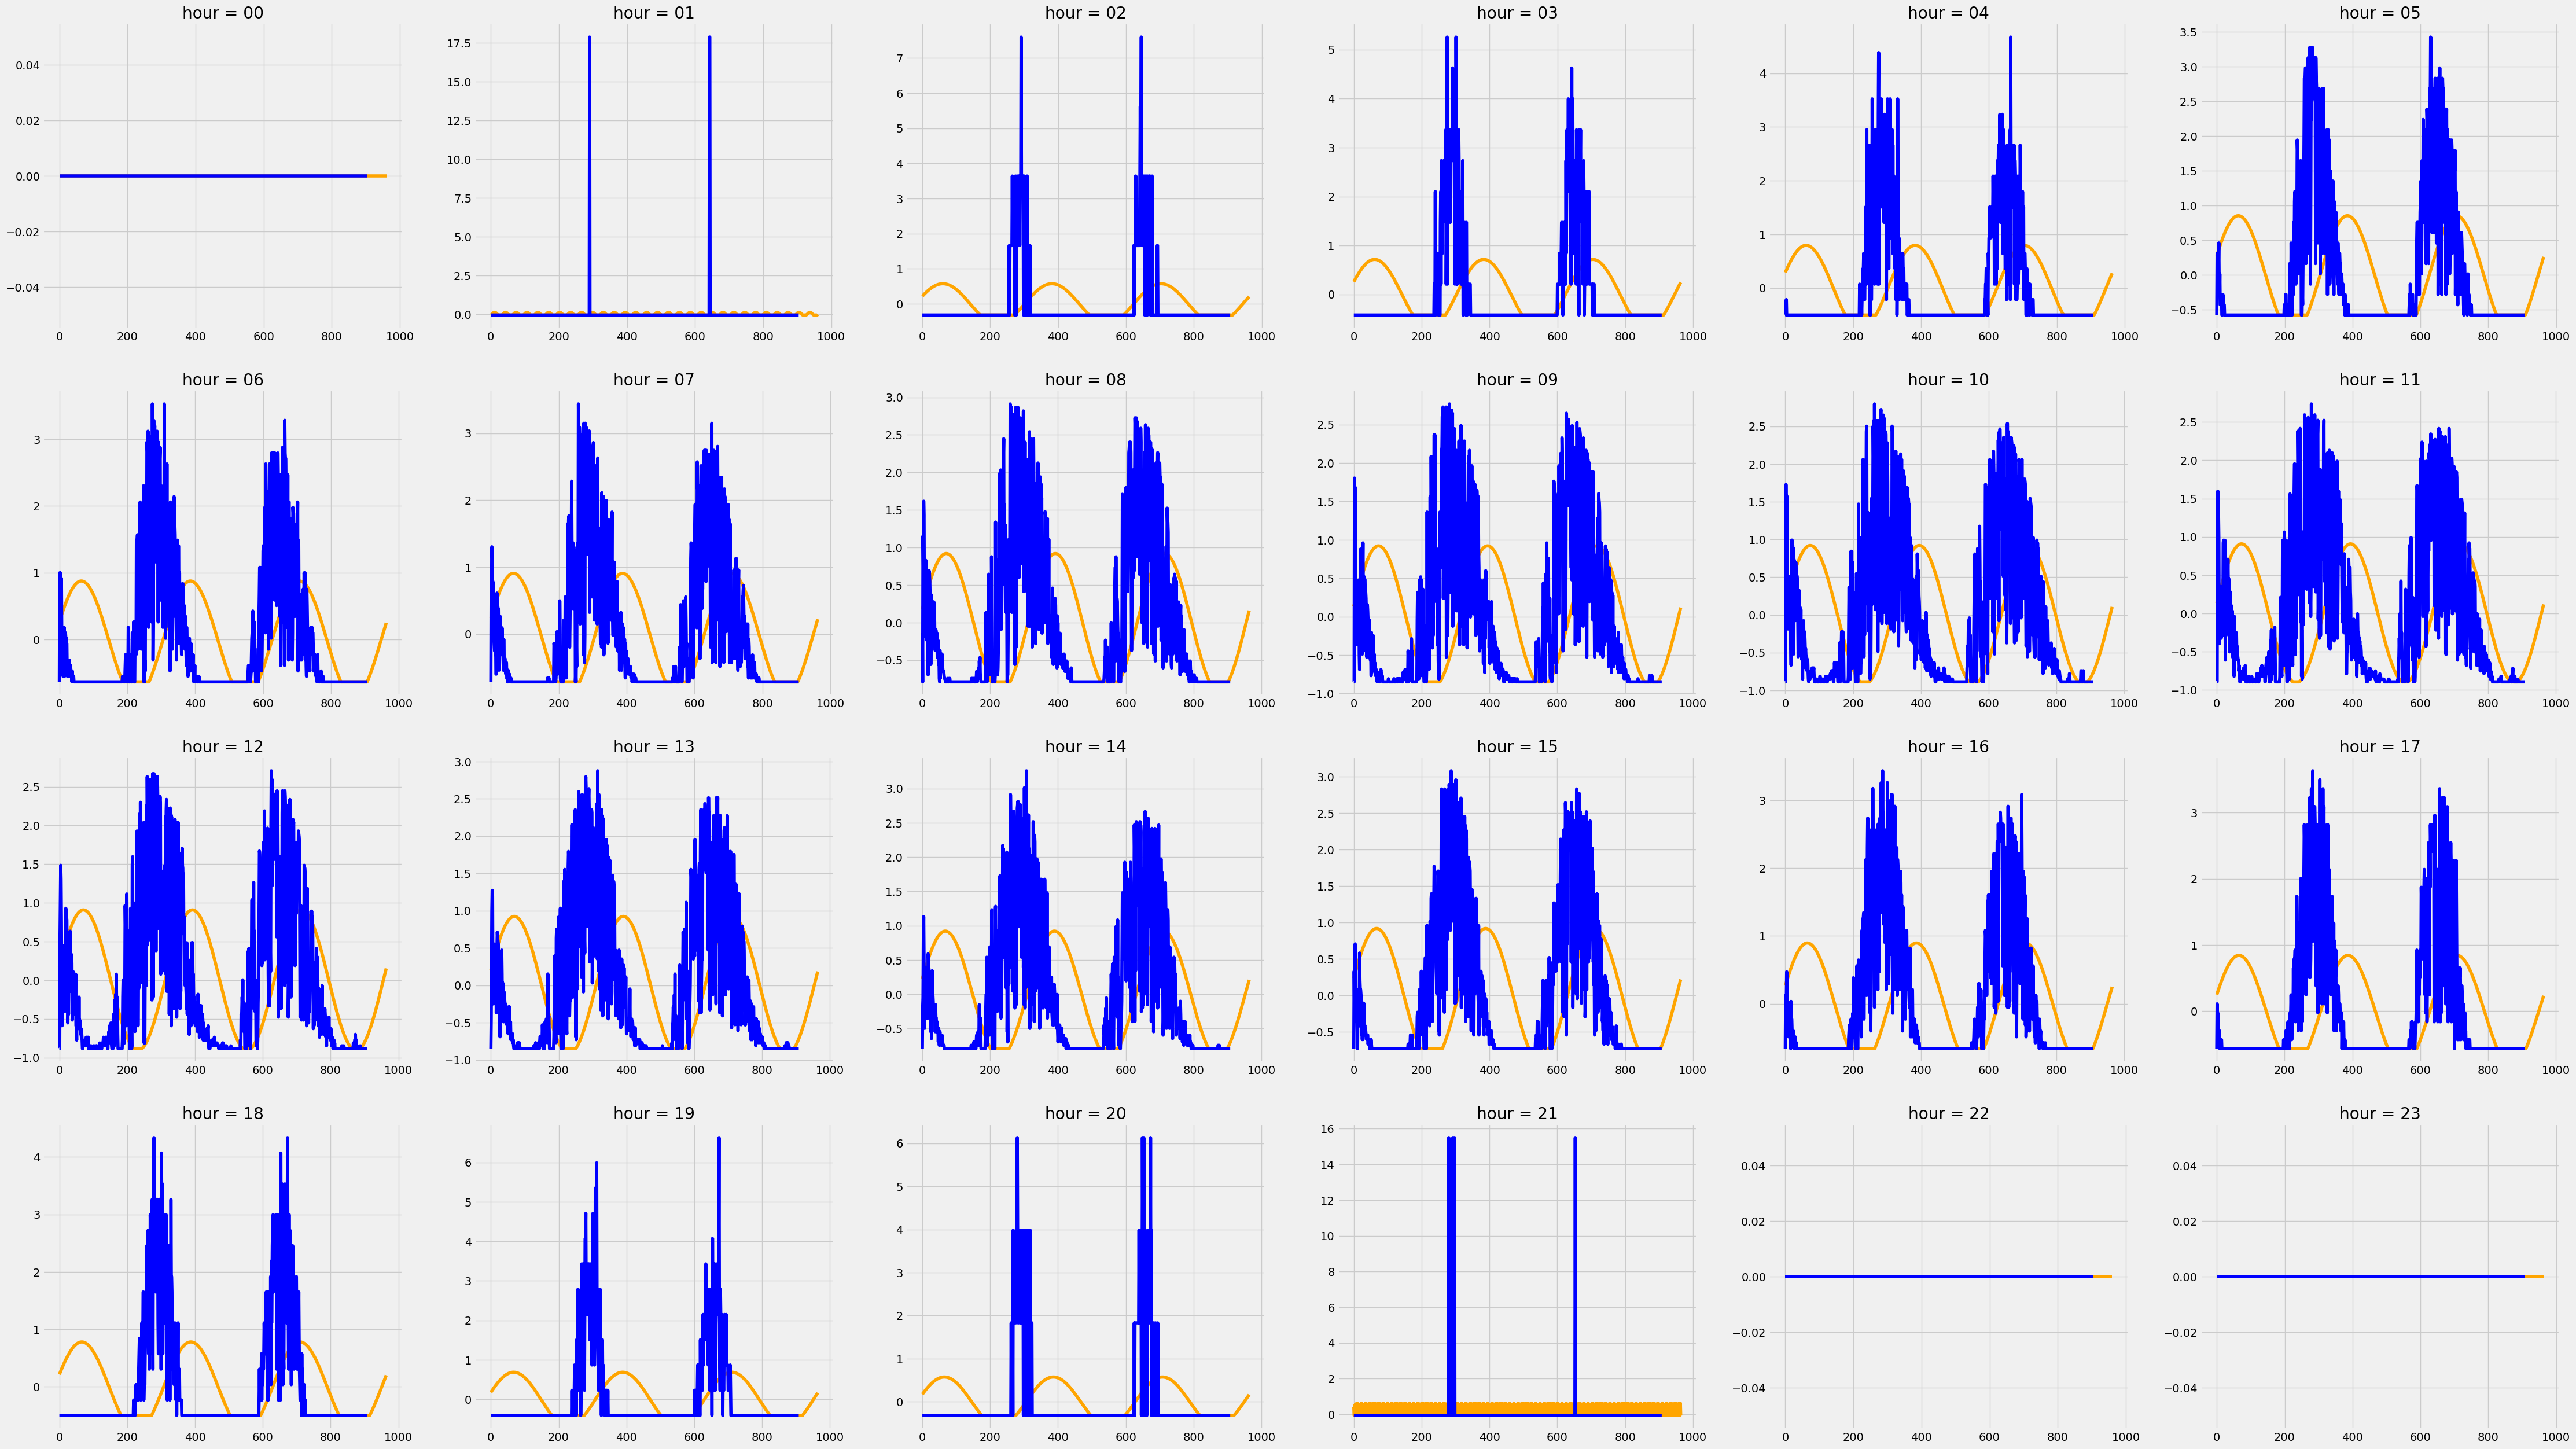

In [8]:
for loc in locations:
    plt.figure(figsize=(50, 30))

    y_pred = s_[loc].get_filtered_signal_on_training_dates()
    y_train = s_[loc].train_normalized
    sp_loc = 1
    for h in hours:
        y_pred_ = np.array(y_pred[h]) 
        plt.subplot(4, 6, sp_loc)
        plt.plot(y_pred_, color='orange')
        plt.plot(np.real(y_train[h]), color='b')
        plt.title(f"hour = {h}")
        sp_loc += 1

# for h in hours: 
#     # print(np.mean(np.array(y_pred[h])), np.std(np.array(y_pred[h])))
#     # print(s_[loc].std_on_h[h], s_[loc].mean_on_h[h])
#     print(np.mean(y_train[h]), np.std(y_train[h]))

    

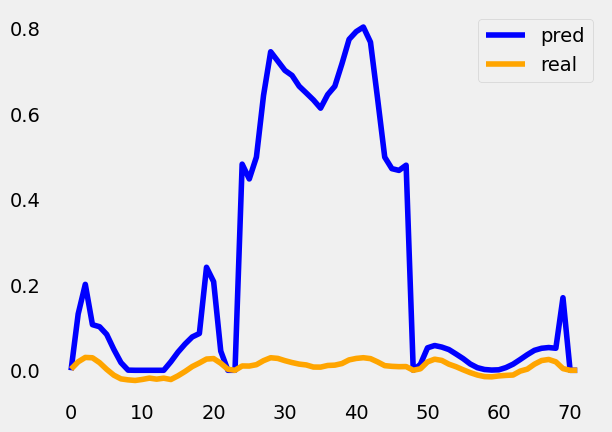

In [9]:
means_pred = []
means_train = []
for loc in locations:
    y_pred = s_[loc].get_filtered_signal_on_training_dates()
    y_train = s_[loc].train_normalized
    for h in hours:
        # print('loc', loc, 'hour', h, np.mean(y_train[loc][h]), np.mean(y_pred_train[loc][h]))
        means_pred.append(np.mean(y_pred[h]))
        means_train.append(np.mean(y_train[h]))

plt.plot(means_pred, c='b', label='pred')
plt.plot(means_train, c='orange', label='real')
plt.legend()
plt.grid()

In [10]:
train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge

train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

In [11]:
X_train_observed_a = pd.merge(X_train_observed_a, train_a, on='date_forecast', how='inner').dropna(subset='pv_measurement').drop(columns='pv_measurement')
X_train_observed_b = pd.merge(X_train_observed_b, train_b, on='date_forecast', how='inner').dropna(subset='pv_measurement').drop(columns='pv_measurement')
X_train_observed_c = pd.merge(X_train_observed_c, train_c, on='date_forecast', how='inner').dropna(subset='pv_measurement').drop(columns='pv_measurement')

In [12]:
from normalization import normalize_list_df, unnorm_df

list_df = [ X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]
dfs, means, stds = normalize_list_df(list_df)
X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = dfs

In [13]:
X_train_observed_a = X_train_observed_a[(X_train_observed_a['date_forecast'] >= params['a']['start_date']) & (X_train_observed_a['date_forecast'] < params['a']['end_date'])]
X_train_observed_b = X_train_observed_b[(X_train_observed_b['date_forecast'] >= params['b']['start_date']) & (X_train_observed_b['date_forecast'] < params['b']['end_date'])]
X_train_observed_c = X_train_observed_c[(X_train_observed_c['date_forecast'] >= params['c']['start_date']) & (X_train_observed_c['date_forecast'] < params['c']['end_date'])]

In [14]:
X_tr_obs_a = { h: X_train_observed_a[X_train_observed_a['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }
X_tr_obs_b = { h: X_train_observed_b[X_train_observed_b['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }
X_tr_obs_c = { h: X_train_observed_c[X_train_observed_c['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }

X_train_a = { h: X_tr_obs_a[h][X_tr_obs_a[h]['date_forecast'] < params['a']['split_date']] for h in hours }
X_train_b = { h: X_tr_obs_b[h][X_tr_obs_b[h]['date_forecast'] < params['b']['split_date']] for h in hours }
X_train_c = { h: X_tr_obs_c[h][X_tr_obs_c[h]['date_forecast'] < params['c']['split_date']] for h in hours }

X_test_a = { h: X_tr_obs_a[h][X_tr_obs_a[h]['date_forecast'] >= params['a']['split_date']] for h in hours }
X_test_b = { h: X_tr_obs_b[h][X_tr_obs_b[h]['date_forecast'] >= params['b']['split_date']] for h in hours }
X_test_c = { h: X_tr_obs_c[h][X_tr_obs_c[h]['date_forecast'] >= params['c']['split_date']] for h in hours }

In [15]:
X_tr_obs_a = { h: normalize_df(X_tr_obs_a[h], X_tr_obs_a[h].columns, 'date_forecast') for h in hours }
X_tr_obs_b = { h: normalize_df(X_tr_obs_b[h], X_tr_obs_b[h].columns, 'date_forecast') for h in hours }
X_tr_obs_c = { h: normalize_df(X_tr_obs_c[h], X_tr_obs_c[h].columns, 'date_forecast') for h in hours }

In [16]:
h = '00'
dates = s_['b'].train_dates[s_['b'].train_dates.dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')]
dates

0       2019-01-01
24      2019-01-02
48      2019-01-03
72      2019-01-04
96      2019-01-05
           ...    
29100   2022-04-28
29124   2022-04-29
29148   2022-04-30
29172   2022-05-01
29196   2022-05-02
Name: time, Length: 1211, dtype: datetime64[us]

In [17]:
s_['b'].end_date

datetime.datetime(2022, 5, 3, 21, 0)

In [18]:
#function to apply XGBoost model
def create_features(df, label=None):
    """
    Creates time series features including datetime and additional columns from the original DataFrame
    """
    # Add additional columns to X
    additional_columns = [
        'absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
        'clear_sky_rad:W', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W',
        'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p',
        'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
        'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
        'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa',
        'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
        'sfc_pressure:hPa', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm',
        'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
        't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
        'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms'
    ]
    
    X = df[additional_columns]
    
    if label:
        y = df[label]
        return X, y
    return X

In [19]:
X_train_a = { h: create_features(X_train_a[h]) for h in hours }
X_test_a = { h: create_features(X_test_a[h]) for h in hours }

X_train_b = { h: create_features(X_train_b[h]) for h in hours }
X_test_b = { h: create_features(X_test_b[h]) for h in hours }

X_train_c = { h: create_features(X_train_c[h]) for h in hours }
X_test_c = { h: create_features(X_test_c[h]) for h in hours }

In [20]:
reg_a = {}
for h in hours: 
    reg_a[h] = xgb.XGBRegressor(n_estimators=10000)
    reg_a[h].fit(X_train_a[h], y_train['a'][h],
          eval_set=[(X_train_a[h], y_train['a'][h]), (X_test_a[h], y_test['a'][h])],
          early_stopping_rounds=50,
          verbose=True) 

KeyError: 'a'

In [ ]:
reg_b = {}
for h in hours: 
    print('hour', h, len(X_train_b[h]), len(y_train['b'][h]))
    reg_b[h] = xgb.XGBRegressor(n_estimators=10000)
    reg_b[h].fit(X_train_b[h], y_train['b'][h],
          eval_set=[(X_train_b[h], y_train['b'][h]), (X_test_b[h], y_test['b'][h])],
          early_stopping_rounds=50,
          verbose=True)

hour 00 1123 1123
[0]	validation_0-rmse:0.86552	validation_1-rmse:0.50232
[1]	validation_0-rmse:0.72981	validation_1-rmse:0.52771
[2]	validation_0-rmse:0.64711	validation_1-rmse:0.55145
[3]	validation_0-rmse:0.59514	validation_1-rmse:0.55647
[4]	validation_0-rmse:0.52915	validation_1-rmse:0.57046
[5]	validation_0-rmse:0.46487	validation_1-rmse:0.61345
[6]	validation_0-rmse:0.43444	validation_1-rmse:0.61200
[7]	validation_0-rmse:0.40511	validation_1-rmse:0.61995
[8]	validation_0-rmse:0.37961	validation_1-rmse:0.61917
[9]	validation_0-rmse:0.35766	validation_1-rmse:0.61827
[10]	validation_0-rmse:0.33914	validation_1-rmse:0.62238
[11]	validation_0-rmse:0.32200	validation_1-rmse:0.62226


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-rmse:0.31251	validation_1-rmse:0.62486
[13]	validation_0-rmse:0.29527	validation_1-rmse:0.62478
[14]	validation_0-rmse:0.29073	validation_1-rmse:0.63120
[15]	validation_0-rmse:0.27088	validation_1-rmse:0.62480
[16]	validation_0-rmse:0.26564	validation_1-rmse:0.62690
[17]	validation_0-rmse:0.25720	validation_1-rmse:0.62795
[18]	validation_0-rmse:0.24607	validation_1-rmse:0.62711
[19]	validation_0-rmse:0.23924	validation_1-rmse:0.63011
[20]	validation_0-rmse:0.23405	validation_1-rmse:0.63670
[21]	validation_0-rmse:0.22174	validation_1-rmse:0.64054
[22]	validation_0-rmse:0.21112	validation_1-rmse:0.64074
[23]	validation_0-rmse:0.20659	validation_1-rmse:0.64210
[24]	validation_0-rmse:0.19866	validation_1-rmse:0.64256
[25]	validation_0-rmse:0.18792	validation_1-rmse:0.64269
[26]	validation_0-rmse:0.17989	validation_1-rmse:0.64267
[27]	validation_0-rmse:0.17556	validation_1-rmse:0.64667
[28]	validation_0-rmse:0.16047	validation_1-rmse:0.65595
[29]	validation_0-rmse:0.15139	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-rmse:0.18629	validation_1-rmse:0.53094
[24]	validation_0-rmse:0.18190	validation_1-rmse:0.52994
[25]	validation_0-rmse:0.17377	validation_1-rmse:0.53011
[26]	validation_0-rmse:0.16205	validation_1-rmse:0.53012
[27]	validation_0-rmse:0.15479	validation_1-rmse:0.53034
[28]	validation_0-rmse:0.14891	validation_1-rmse:0.53211
[29]	validation_0-rmse:0.14545	validation_1-rmse:0.53309
[30]	validation_0-rmse:0.14110	validation_1-rmse:0.53304
[31]	validation_0-rmse:0.13705	validation_1-rmse:0.53277
[32]	validation_0-rmse:0.13567	validation_1-rmse:0.53258
[33]	validation_0-rmse:0.13109	validation_1-rmse:0.53270
[34]	validation_0-rmse:0.12751	validation_1-rmse:0.53580
[35]	validation_0-rmse:0.12616	validation_1-rmse:0.53593
[36]	validation_0-rmse:0.12071	validation_1-rmse:0.53412
[37]	validation_0-rmse:0.11901	validation_1-rmse:0.53433
[38]	validation_0-rmse:0.11513	validation_1-rmse:0.53444
[39]	validation_0-rmse:0.10930	validation_1-rmse:0.53445
[40]	validation_0-rmse:0.10556	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:0.23369	validation_1-rmse:0.52835
[16]	validation_0-rmse:0.22788	validation_1-rmse:0.52955
[17]	validation_0-rmse:0.21307	validation_1-rmse:0.52963
[18]	validation_0-rmse:0.20828	validation_1-rmse:0.53130
[19]	validation_0-rmse:0.20263	validation_1-rmse:0.53095
[20]	validation_0-rmse:0.18855	validation_1-rmse:0.53107
[21]	validation_0-rmse:0.18194	validation_1-rmse:0.53243
[22]	validation_0-rmse:0.17757	validation_1-rmse:0.53301
[23]	validation_0-rmse:0.17053	validation_1-rmse:0.53500
[24]	validation_0-rmse:0.16632	validation_1-rmse:0.54062
[25]	validation_0-rmse:0.15969	validation_1-rmse:0.54017
[26]	validation_0-rmse:0.15669	validation_1-rmse:0.54035
[27]	validation_0-rmse:0.15116	validation_1-rmse:0.54326
[28]	validation_0-rmse:0.14509	validation_1-rmse:0.54295
[29]	validation_0-rmse:0.13812	validation_1-rmse:0.54681
[30]	validation_0-rmse:0.13134	validation_1-rmse:0.54678
[31]	validation_0-rmse:0.12837	validation_1-rmse:0.54695
[32]	validation_0-rmse:0.12517	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-rmse:0.06250	validation_1-rmse:0.44632
[48]	validation_0-rmse:0.06098	validation_1-rmse:0.44621
[49]	validation_0-rmse:0.05837	validation_1-rmse:0.44735
[50]	validation_0-rmse:0.05756	validation_1-rmse:0.44731
[51]	validation_0-rmse:0.05526	validation_1-rmse:0.44719
[52]	validation_0-rmse:0.05456	validation_1-rmse:0.44864
hour 05 1129 1129
[0]	validation_0-rmse:0.77032	validation_1-rmse:0.44838
[1]	validation_0-rmse:0.59095	validation_1-rmse:0.37145
[2]	validation_0-rmse:0.46304	validation_1-rmse:0.31976
[3]	validation_0-rmse:0.37390	validation_1-rmse:0.31178
[4]	validation_0-rmse:0.30724	validation_1-rmse:0.31746
[5]	validation_0-rmse:0.26291	validation_1-rmse:0.31683
[6]	validation_0-rmse:0.22872	validation_1-rmse:0.31957
[7]	validation_0-rmse:0.20020	validation_1-rmse:0.31716
[8]	validation_0-rmse:0.18159	validation_1-rmse:0.32145
[9]	validation_0-rmse:0.17337	validation_1-rmse:0.32525
[10]	validation_0-rmse:0.15960	validation_1-rmse:0.32561
[11]	validation_0-rmse:

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-rmse:0.03710	validation_1-rmse:0.36228
[51]	validation_0-rmse:0.03540	validation_1-rmse:0.36339
[52]	validation_0-rmse:0.03440	validation_1-rmse:0.36357
[53]	validation_0-rmse:0.03377	validation_1-rmse:0.36322
[54]	validation_0-rmse:0.03270	validation_1-rmse:0.36322
[55]	validation_0-rmse:0.03165	validation_1-rmse:0.36356
[56]	validation_0-rmse:0.02983	validation_1-rmse:0.36368
[57]	validation_0-rmse:0.02879	validation_1-rmse:0.36370
[58]	validation_0-rmse:0.02783	validation_1-rmse:0.36360
[59]	validation_0-rmse:0.02638	validation_1-rmse:0.36344
[60]	validation_0-rmse:0.02498	validation_1-rmse:0.36338
hour 07 1129 1129
[0]	validation_0-rmse:0.76026	validation_1-rmse:0.63956
[1]	validation_0-rmse:0.58216	validation_1-rmse:0.54036
[2]	validation_0-rmse:0.46081	validation_1-rmse:0.50071
[3]	validation_0-rmse:0.36815	validation_1-rmse:0.47348
[4]	validation_0-rmse:0.31074	validation_1-rmse:0.46299
[5]	validation_0-rmse:0.26570	validation_1-rmse:0.45784
[6]	validation_0-rm

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:0.07315	validation_1-rmse:0.60366
[35]	validation_0-rmse:0.07086	validation_1-rmse:0.60328
[36]	validation_0-rmse:0.06726	validation_1-rmse:0.60486
[37]	validation_0-rmse:0.06531	validation_1-rmse:0.60525
[38]	validation_0-rmse:0.06333	validation_1-rmse:0.60361
[39]	validation_0-rmse:0.06189	validation_1-rmse:0.60410
[40]	validation_0-rmse:0.05951	validation_1-rmse:0.60789
[41]	validation_0-rmse:0.05615	validation_1-rmse:0.60838
[42]	validation_0-rmse:0.05370	validation_1-rmse:0.60626
[43]	validation_0-rmse:0.05317	validation_1-rmse:0.60601
[44]	validation_0-rmse:0.05199	validation_1-rmse:0.60601
[45]	validation_0-rmse:0.04959	validation_1-rmse:0.60717
[46]	validation_0-rmse:0.04863	validation_1-rmse:0.60725
[47]	validation_0-rmse:0.04766	validation_1-rmse:0.60704
[48]	validation_0-rmse:0.04557	validation_1-rmse:0.60703
[49]	validation_0-rmse:0.04382	validation_1-rmse:0.60672
[50]	validation_0-rmse:0.04365	validation_1-rmse:0.60672
[51]	validation_0-rmse:0.04247	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-rmse:0.05890	validation_1-rmse:0.68535
[50]	validation_0-rmse:0.05838	validation_1-rmse:0.68536
[51]	validation_0-rmse:0.05720	validation_1-rmse:0.68528
[52]	validation_0-rmse:0.05444	validation_1-rmse:0.68531
[53]	validation_0-rmse:0.05235	validation_1-rmse:0.68586
[54]	validation_0-rmse:0.05043	validation_1-rmse:0.68578
[55]	validation_0-rmse:0.04958	validation_1-rmse:0.68570
hour 11 1129 1129
[0]	validation_0-rmse:0.77690	validation_1-rmse:0.82275
[1]	validation_0-rmse:0.62461	validation_1-rmse:0.75820
[2]	validation_0-rmse:0.51612	validation_1-rmse:0.67751
[3]	validation_0-rmse:0.43648	validation_1-rmse:0.64444
[4]	validation_0-rmse:0.38749	validation_1-rmse:0.60700
[5]	validation_0-rmse:0.34531	validation_1-rmse:0.60074
[6]	validation_0-rmse:0.30665	validation_1-rmse:0.60778
[7]	validation_0-rmse:0.27956	validation_1-rmse:0.62300
[8]	validation_0-rmse:0.26187	validation_1-rmse:0.61972
[9]	validation_0-rmse:0.24904	validation_1-rmse:0.62270
[10]	validation_0-rmse:

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:0.23950	validation_1-rmse:0.70519
[9]	validation_0-rmse:0.22400	validation_1-rmse:0.70459
[10]	validation_0-rmse:0.21086	validation_1-rmse:0.70105
[11]	validation_0-rmse:0.19948	validation_1-rmse:0.70063
[12]	validation_0-rmse:0.18913	validation_1-rmse:0.69534
[13]	validation_0-rmse:0.18143	validation_1-rmse:0.69915
[14]	validation_0-rmse:0.17073	validation_1-rmse:0.70697
[15]	validation_0-rmse:0.16374	validation_1-rmse:0.70065
[16]	validation_0-rmse:0.15811	validation_1-rmse:0.70209
[17]	validation_0-rmse:0.15234	validation_1-rmse:0.70212
[18]	validation_0-rmse:0.15001	validation_1-rmse:0.70144
[19]	validation_0-rmse:0.14485	validation_1-rmse:0.70103
[20]	validation_0-rmse:0.13847	validation_1-rmse:0.70036
[21]	validation_0-rmse:0.13522	validation_1-rmse:0.70037
[22]	validation_0-rmse:0.12435	validation_1-rmse:0.70257
[23]	validation_0-rmse:0.12198	validation_1-rmse:0.70472
[24]	validation_0-rmse:0.11636	validation_1-rmse:0.70442
[25]	validation_0-rmse:0.10954	va

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-rmse:0.04555	validation_1-rmse:0.40812
[45]	validation_0-rmse:0.04504	validation_1-rmse:0.40811
[46]	validation_0-rmse:0.04223	validation_1-rmse:0.40985
[47]	validation_0-rmse:0.04122	validation_1-rmse:0.40922
[48]	validation_0-rmse:0.03965	validation_1-rmse:0.40904
[49]	validation_0-rmse:0.03748	validation_1-rmse:0.40905
[50]	validation_0-rmse:0.03635	validation_1-rmse:0.40988
[51]	validation_0-rmse:0.03492	validation_1-rmse:0.40982
[52]	validation_0-rmse:0.03419	validation_1-rmse:0.40965
[53]	validation_0-rmse:0.03303	validation_1-rmse:0.40921
[54]	validation_0-rmse:0.03106	validation_1-rmse:0.40949
[55]	validation_0-rmse:0.03085	validation_1-rmse:0.40968
[56]	validation_0-rmse:0.02996	validation_1-rmse:0.40991
[57]	validation_0-rmse:0.02910	validation_1-rmse:0.40997
[58]	validation_0-rmse:0.02829	validation_1-rmse:0.41040
hour 15 1129 1129
[0]	validation_0-rmse:0.76678	validation_1-rmse:0.49265
[1]	validation_0-rmse:0.58974	validation_1-rmse:0.40405
[2]	validation_

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-rmse:0.03265	validation_1-rmse:0.41101
[47]	validation_0-rmse:0.03068	validation_1-rmse:0.41065
[48]	validation_0-rmse:0.02990	validation_1-rmse:0.41034
[49]	validation_0-rmse:0.02871	validation_1-rmse:0.41012
[50]	validation_0-rmse:0.02782	validation_1-rmse:0.40986
[51]	validation_0-rmse:0.02632	validation_1-rmse:0.41113
[52]	validation_0-rmse:0.02532	validation_1-rmse:0.41103
[53]	validation_0-rmse:0.02510	validation_1-rmse:0.41103
hour 17 1129 1129
[0]	validation_0-rmse:0.77355	validation_1-rmse:0.46048
[1]	validation_0-rmse:0.59913	validation_1-rmse:0.40786
[2]	validation_0-rmse:0.48072	validation_1-rmse:0.37902
[3]	validation_0-rmse:0.39192	validation_1-rmse:0.37036
[4]	validation_0-rmse:0.33636	validation_1-rmse:0.36776
[5]	validation_0-rmse:0.29132	validation_1-rmse:0.36456
[6]	validation_0-rmse:0.25997	validation_1-rmse:0.36422
[7]	validation_0-rmse:0.23791	validation_1-rmse:0.36141
[8]	validation_0-rmse:0.21396	validation_1-rmse:0.35766
[9]	validation_0-rmse:

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-rmse:0.03774	validation_1-rmse:0.50272
[53]	validation_0-rmse:0.03691	validation_1-rmse:0.50272
[54]	validation_0-rmse:0.03583	validation_1-rmse:0.50362
[55]	validation_0-rmse:0.03400	validation_1-rmse:0.50366
[56]	validation_0-rmse:0.03292	validation_1-rmse:0.50447
[57]	validation_0-rmse:0.03114	validation_1-rmse:0.50405
[58]	validation_0-rmse:0.02962	validation_1-rmse:0.50413
hour 19 1129 1129
[0]	validation_0-rmse:0.88340	validation_1-rmse:0.53417
[1]	validation_0-rmse:0.75799	validation_1-rmse:0.50455
[2]	validation_0-rmse:0.66217	validation_1-rmse:0.47688
[3]	validation_0-rmse:0.61127	validation_1-rmse:0.45289
[4]	validation_0-rmse:0.56095	validation_1-rmse:0.45415
[5]	validation_0-rmse:0.53571	validation_1-rmse:0.45739
[6]	validation_0-rmse:0.47497	validation_1-rmse:0.45778
[7]	validation_0-rmse:0.42409	validation_1-rmse:0.45823
[8]	validation_0-rmse:0.39742	validation_1-rmse:0.45656
[9]	validation_0-rmse:0.36523	validation_1-rmse:0.46225
[10]	validation_0-rmse:

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


hour 21 1129 1129
[0]	validation_0-rmse:0.85425	validation_1-rmse:0.57718
[1]	validation_0-rmse:0.74341	validation_1-rmse:0.57547
[2]	validation_0-rmse:0.65745	validation_1-rmse:0.60415
[3]	validation_0-rmse:0.56883	validation_1-rmse:0.65835
[4]	validation_0-rmse:0.51656	validation_1-rmse:0.66138
[5]	validation_0-rmse:0.47264	validation_1-rmse:0.66709
[6]	validation_0-rmse:0.43421	validation_1-rmse:0.67653
[7]	validation_0-rmse:0.41283	validation_1-rmse:0.70358
[8]	validation_0-rmse:0.38990	validation_1-rmse:0.70338
[9]	validation_0-rmse:0.34447	validation_1-rmse:0.70541
[10]	validation_0-rmse:0.31617	validation_1-rmse:0.71716
[11]	validation_0-rmse:0.30560	validation_1-rmse:0.72870
[12]	validation_0-rmse:0.28915	validation_1-rmse:0.74469
[13]	validation_0-rmse:0.28229	validation_1-rmse:0.74585
[14]	validation_0-rmse:0.27495	validation_1-rmse:0.74558
[15]	validation_0-rmse:0.26355	validation_1-rmse:0.74569
[16]	validation_0-rmse:0.25534	validation_1-rmse:0.74578
[17]	validation_0-rmse:

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:0.71019	validation_1-rmse:0.50358
[2]	validation_0-rmse:0.60841	validation_1-rmse:0.50482
[3]	validation_0-rmse:0.52366	validation_1-rmse:0.50953
[4]	validation_0-rmse:0.46961	validation_1-rmse:0.50992
[5]	validation_0-rmse:0.42629	validation_1-rmse:0.50718
[6]	validation_0-rmse:0.39163	validation_1-rmse:0.51089
[7]	validation_0-rmse:0.37219	validation_1-rmse:0.51153
[8]	validation_0-rmse:0.35847	validation_1-rmse:0.52296
[9]	validation_0-rmse:0.34280	validation_1-rmse:0.52474
[10]	validation_0-rmse:0.30392	validation_1-rmse:0.52328
[11]	validation_0-rmse:0.26985	validation_1-rmse:0.52284
[12]	validation_0-rmse:0.26115	validation_1-rmse:0.52578
[13]	validation_0-rmse:0.25518	validation_1-rmse:0.52965
[14]	validation_0-rmse:0.24416	validation_1-rmse:0.52885
[15]	validation_0-rmse:0.23848	validation_1-rmse:0.53342
[16]	validation_0-rmse:0.22801	validation_1-rmse:0.53340
[17]	validation_0-rmse:0.21810	validation_1-rmse:0.52923
[18]	validation_0-rmse:0.20182	validatio

In [ ]:
reg_c = {}
for h in hours:
    reg_c[h] = xgb.XGBRegressor(n_estimators=10000)
    reg_c[h].fit(X_train_c[h], y_train['c'][h],
            eval_set=[(X_train_c[h], y_train['c'][h]), (X_test_c[h], y_test['c'][h])],
            early_stopping_rounds=50,
            verbose=True)

[0]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[1]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[2]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[3]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[4]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[5]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[6]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[7]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[8]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[9]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[10]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[11]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[12]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[13]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[14]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[15]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[16]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[17]	validation_0-rmse:0.00000	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:0.00504	validation_1-rmse:0.00007
[35]	validation_0-rmse:0.00471	validation_1-rmse:0.00009
[36]	validation_0-rmse:0.00412	validation_1-rmse:0.00006
[37]	validation_0-rmse:0.00390	validation_1-rmse:0.00010
[38]	validation_0-rmse:0.00337	validation_1-rmse:0.00007
[39]	validation_0-rmse:0.00324	validation_1-rmse:0.00007
[40]	validation_0-rmse:0.00287	validation_1-rmse:0.00051
[41]	validation_0-rmse:0.00243	validation_1-rmse:0.00051
[42]	validation_0-rmse:0.00224	validation_1-rmse:0.00077
[43]	validation_0-rmse:0.00197	validation_1-rmse:0.00077
[44]	validation_0-rmse:0.00175	validation_1-rmse:0.00086
[45]	validation_0-rmse:0.00164	validation_1-rmse:0.00086
[46]	validation_0-rmse:0.00146	validation_1-rmse:0.00086
[47]	validation_0-rmse:0.00139	validation_1-rmse:0.00086
[48]	validation_0-rmse:0.00124	validation_1-rmse:0.00086
[49]	validation_0-rmse:0.00117	validation_1-rmse:0.00092
[50]	validation_0-rmse:0.00102	validation_1-rmse:0.00092
[51]	validation_0-rmse:0.00092	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:0.06347	validation_1-rmse:0.10343
[16]	validation_0-rmse:0.06023	validation_1-rmse:0.10201
[17]	validation_0-rmse:0.05600	validation_1-rmse:0.10200
[18]	validation_0-rmse:0.05144	validation_1-rmse:0.10194
[19]	validation_0-rmse:0.04898	validation_1-rmse:0.10195
[20]	validation_0-rmse:0.04591	validation_1-rmse:0.10197
[21]	validation_0-rmse:0.04336	validation_1-rmse:0.10194
[22]	validation_0-rmse:0.03775	validation_1-rmse:0.10192
[23]	validation_0-rmse:0.03517	validation_1-rmse:0.10193
[24]	validation_0-rmse:0.03296	validation_1-rmse:0.10201
[25]	validation_0-rmse:0.03120	validation_1-rmse:0.10205
[26]	validation_0-rmse:0.02968	validation_1-rmse:0.10204
[27]	validation_0-rmse:0.02841	validation_1-rmse:0.10204
[28]	validation_0-rmse:0.02753	validation_1-rmse:0.10204
[29]	validation_0-rmse:0.02462	validation_1-rmse:0.10204
[30]	validation_0-rmse:0.02293	validation_1-rmse:0.10139
[31]	validation_0-rmse:0.02200	validation_1-rmse:0.10139
[32]	validation_0-rmse:0.02063	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:0.03532	validation_1-rmse:0.29569
[32]	validation_0-rmse:0.03331	validation_1-rmse:0.29691
[33]	validation_0-rmse:0.03117	validation_1-rmse:0.29706
[34]	validation_0-rmse:0.03030	validation_1-rmse:0.29747
[35]	validation_0-rmse:0.02926	validation_1-rmse:0.29706
[36]	validation_0-rmse:0.02845	validation_1-rmse:0.29661
[37]	validation_0-rmse:0.02680	validation_1-rmse:0.29746
[38]	validation_0-rmse:0.02489	validation_1-rmse:0.29719
[39]	validation_0-rmse:0.02298	validation_1-rmse:0.29700
[40]	validation_0-rmse:0.02284	validation_1-rmse:0.29715
[41]	validation_0-rmse:0.02166	validation_1-rmse:0.29683
[42]	validation_0-rmse:0.02104	validation_1-rmse:0.29684
[43]	validation_0-rmse:0.02066	validation_1-rmse:0.29694
[44]	validation_0-rmse:0.02048	validation_1-rmse:0.29694
[45]	validation_0-rmse:0.02004	validation_1-rmse:0.29694
[46]	validation_0-rmse:0.01885	validation_1-rmse:0.29720
[47]	validation_0-rmse:0.01816	validation_1-rmse:0.29719
[48]	validation_0-rmse:0.01764	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.03025	validation_1-rmse:0.60466
[41]	validation_0-rmse:0.02920	validation_1-rmse:0.60539
[42]	validation_0-rmse:0.02862	validation_1-rmse:0.60547
[43]	validation_0-rmse:0.02743	validation_1-rmse:0.60559
[44]	validation_0-rmse:0.02696	validation_1-rmse:0.60573
[45]	validation_0-rmse:0.02640	validation_1-rmse:0.60574
[46]	validation_0-rmse:0.02559	validation_1-rmse:0.60586
[47]	validation_0-rmse:0.02512	validation_1-rmse:0.60581
[48]	validation_0-rmse:0.02418	validation_1-rmse:0.60554
[49]	validation_0-rmse:0.02288	validation_1-rmse:0.60521
[50]	validation_0-rmse:0.02263	validation_1-rmse:0.60523
[51]	validation_0-rmse:0.02172	validation_1-rmse:0.60460
[52]	validation_0-rmse:0.02061	validation_1-rmse:0.60266
[53]	validation_0-rmse:0.02022	validation_1-rmse:0.60257
[54]	validation_0-rmse:0.01941	validation_1-rmse:0.60240
[55]	validation_0-rmse:0.01878	validation_1-rmse:0.60242
[56]	validation_0-rmse:0.01851	validation_1-rmse:0.60238
[57]	validation_0-rmse:0.01760	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-rmse:0.03864	validation_1-rmse:0.51132
[43]	validation_0-rmse:0.03809	validation_1-rmse:0.51158
[44]	validation_0-rmse:0.03767	validation_1-rmse:0.51168
[45]	validation_0-rmse:0.03717	validation_1-rmse:0.51159
[46]	validation_0-rmse:0.03587	validation_1-rmse:0.51201
[47]	validation_0-rmse:0.03439	validation_1-rmse:0.51224
[48]	validation_0-rmse:0.03309	validation_1-rmse:0.51233
[49]	validation_0-rmse:0.03193	validation_1-rmse:0.51218
[50]	validation_0-rmse:0.03092	validation_1-rmse:0.51169
[51]	validation_0-rmse:0.02976	validation_1-rmse:0.51127
[52]	validation_0-rmse:0.02906	validation_1-rmse:0.51110
[53]	validation_0-rmse:0.02776	validation_1-rmse:0.51085
[54]	validation_0-rmse:0.02637	validation_1-rmse:0.51107
[0]	validation_0-rmse:0.74710	validation_1-rmse:0.77686
[1]	validation_0-rmse:0.57137	validation_1-rmse:0.72373
[2]	validation_0-rmse:0.44473	validation_1-rmse:0.66262
[3]	validation_0-rmse:0.35674	validation_1-rmse:0.63705
[4]	validation_0-rmse:0.29105	valid

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.09547	validation_1-rmse:0.59581
[21]	validation_0-rmse:0.08872	validation_1-rmse:0.59618
[22]	validation_0-rmse:0.08593	validation_1-rmse:0.59641
[23]	validation_0-rmse:0.08448	validation_1-rmse:0.59638
[24]	validation_0-rmse:0.08203	validation_1-rmse:0.59761
[25]	validation_0-rmse:0.07865	validation_1-rmse:0.59674
[26]	validation_0-rmse:0.07356	validation_1-rmse:0.59572
[27]	validation_0-rmse:0.07265	validation_1-rmse:0.59481
[28]	validation_0-rmse:0.07090	validation_1-rmse:0.59522
[29]	validation_0-rmse:0.06874	validation_1-rmse:0.59609
[30]	validation_0-rmse:0.06717	validation_1-rmse:0.59740
[31]	validation_0-rmse:0.06536	validation_1-rmse:0.59674
[32]	validation_0-rmse:0.06120	validation_1-rmse:0.59655
[33]	validation_0-rmse:0.05835	validation_1-rmse:0.59342
[34]	validation_0-rmse:0.05748	validation_1-rmse:0.59384
[35]	validation_0-rmse:0.05705	validation_1-rmse:0.59396
[36]	validation_0-rmse:0.05622	validation_1-rmse:0.59400
[37]	validation_0-rmse:0.05320	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-rmse:0.02457	validation_1-rmse:0.50062
[0]	validation_0-rmse:0.74846	validation_1-rmse:0.54033
[1]	validation_0-rmse:0.56139	validation_1-rmse:0.46680
[2]	validation_0-rmse:0.43134	validation_1-rmse:0.43817
[3]	validation_0-rmse:0.33637	validation_1-rmse:0.42542
[4]	validation_0-rmse:0.27248	validation_1-rmse:0.41161
[5]	validation_0-rmse:0.22227	validation_1-rmse:0.41272
[6]	validation_0-rmse:0.18920	validation_1-rmse:0.40258
[7]	validation_0-rmse:0.16009	validation_1-rmse:0.39723
[8]	validation_0-rmse:0.13790	validation_1-rmse:0.39777
[9]	validation_0-rmse:0.12384	validation_1-rmse:0.39223
[10]	validation_0-rmse:0.11493	validation_1-rmse:0.39446
[11]	validation_0-rmse:0.10249	validation_1-rmse:0.39442
[12]	validation_0-rmse:0.09244	validation_1-rmse:0.39613
[13]	validation_0-rmse:0.08543	validation_1-rmse:0.39560
[14]	validation_0-rmse:0.07994	validation_1-rmse:0.39425
[15]	validation_0-rmse:0.07444	validation_1-rmse:0.39344
[16]	validation_0-rmse:0.07060	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.11394	validation_1-rmse:0.31551
[11]	validation_0-rmse:0.10558	validation_1-rmse:0.31745
[12]	validation_0-rmse:0.09869	validation_1-rmse:0.31768
[13]	validation_0-rmse:0.09048	validation_1-rmse:0.32025
[14]	validation_0-rmse:0.08447	validation_1-rmse:0.31969
[15]	validation_0-rmse:0.08129	validation_1-rmse:0.31914
[16]	validation_0-rmse:0.07369	validation_1-rmse:0.31797
[17]	validation_0-rmse:0.06797	validation_1-rmse:0.31887
[18]	validation_0-rmse:0.06487	validation_1-rmse:0.32105
[19]	validation_0-rmse:0.06300	validation_1-rmse:0.32032
[20]	validation_0-rmse:0.05802	validation_1-rmse:0.32251
[21]	validation_0-rmse:0.05252	validation_1-rmse:0.32414
[22]	validation_0-rmse:0.04903	validation_1-rmse:0.32417
[23]	validation_0-rmse:0.04730	validation_1-rmse:0.32429
[24]	validation_0-rmse:0.04346	validation_1-rmse:0.32489
[25]	validation_0-rmse:0.03948	validation_1-rmse:0.32473
[26]	validation_0-rmse:0.03687	validation_1-rmse:0.32523
[27]	validation_0-rmse:0.03611	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-rmse:0.03938	validation_1-rmse:0.11917
[23]	validation_0-rmse:0.03890	validation_1-rmse:0.11917
[24]	validation_0-rmse:0.03479	validation_1-rmse:0.11780
[25]	validation_0-rmse:0.03243	validation_1-rmse:0.11780
[26]	validation_0-rmse:0.03061	validation_1-rmse:0.11749
[27]	validation_0-rmse:0.03005	validation_1-rmse:0.11733
[28]	validation_0-rmse:0.02747	validation_1-rmse:0.11729
[29]	validation_0-rmse:0.02693	validation_1-rmse:0.11730
[30]	validation_0-rmse:0.02553	validation_1-rmse:0.11584
[31]	validation_0-rmse:0.02229	validation_1-rmse:0.11588
[32]	validation_0-rmse:0.01951	validation_1-rmse:0.11547
[33]	validation_0-rmse:0.01883	validation_1-rmse:0.11546
[34]	validation_0-rmse:0.01752	validation_1-rmse:0.11574
[35]	validation_0-rmse:0.01608	validation_1-rmse:0.11612
[36]	validation_0-rmse:0.01496	validation_1-rmse:0.11590
[37]	validation_0-rmse:0.01420	validation_1-rmse:0.11590
[38]	validation_0-rmse:0.01295	validation_1-rmse:0.11574
[39]	validation_0-rmse:0.01247	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-rmse:0.00114	validation_1-rmse:0.00006
[56]	validation_0-rmse:0.00106	validation_1-rmse:0.00006
[57]	validation_0-rmse:0.00097	validation_1-rmse:0.00006
[58]	validation_0-rmse:0.00089	validation_1-rmse:0.00006
[59]	validation_0-rmse:0.00080	validation_1-rmse:0.00006
[60]	validation_0-rmse:0.00072	validation_1-rmse:0.00006
[61]	validation_0-rmse:0.00068	validation_1-rmse:0.00006
[62]	validation_0-rmse:0.00062	validation_1-rmse:0.00006
[63]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[64]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[65]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[66]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[67]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[68]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[69]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[70]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[71]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[72]	validation_0-rmse:0.00058	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
X_te_est_a = { h: X_test_estimated_a[X_test_estimated_a['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }
X_te_est_b = { h: X_test_estimated_b[X_test_estimated_b['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }
X_te_est_c = { h: X_test_estimated_c[X_test_estimated_c['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }

In [ ]:
X_test_estimated_a.describe()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,2880.000000,2880,2.880000e+03,2.880000e+03,2.087000e+03,2.880000e+03,2.880000e+03,2.582000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2880.0,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2880.000000,2.880000e+03,2.880000e+03,2.880000e+03,2880.000000,2880.0,2.880000e+03,2.880000e+03,2880.000000,0.0,2880.0,2880.0,2880.0,2.880000e+03,2.880000e+03,2.880000e+03,2880.000000,2880.000000,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2880.0
mean,0.000000,2023-06-05 22:16:30,-8.477105e-08,-4.874336e-07,1.462270e-08,2.649095e-08,6.622739e-08,1.181936e-08,-7.947286e-09,6.357829e-07,9.271834e-08,7.947286e-09,-4.768372e-08,5.298191e-09,-7.947286e-08,0.0,6.622738e-09,-3.973643e-09,6.622738e-09,6.622738e-09,6.622738e-09,3.708734e-08,-2.914005e-08,0.000002,-2.914005e-08,3.443824e-08,5.933974e-07,-0.000003,0.0,2.119276e-08,4.503462e-08,0.000004,NaN,0.0,0.0,0.0,-6.622738e-09,-5.695555e-08,2.384186e-08,0.000000,0.000002,2.172258e-07,8.477105e-08,-9.536743e-08,5.298191e-08,3.178915e-08,0.0
min,-2.087408,2023-05-01 00:00:00,-2.297216e+00,-2.558509e+00,-1.024305e+00,-1.111906e+00,-1.108472e+00,-8.711684e-01,-1.896279e-01,-2.926221e+00,-1.074809e+00,-1.094162e+00,-6.641563e-01,-6.731237e-01,-1.707789e+00,0.0,-2.635689e-02,-1.863390e-02,-2.635689e-02,-2.635689e-02,-2.635689e-02,-1.961415e+00,-5.392587e-01,-3.176496,-2.270976e-01,-2.612002e-01,-3.131193e+00,-3.124871,0.0,-2.464321e-01,-2.959709e+00,-3.120292,NaN,0.0,0.0,-0.0,-2.927680e-01,-1.639950e+00,-1.709484e+00,-0.573553,-1.879636,-1.828270e+00,-2.034801e+00,-1.706973e+00,-2.221698e+00,-2.795085e+00,-0.0
25%,-0.791376,2023-05-23 11:56:15,-6.910611e-01,-7.521448e-01,-7.175814e-01,-1.062294e+00,-1.061909e+00,-6.440097e-01,-1.896279e-01,-6.451821e-01,-9.836619e-01,-9.766264e-01,-6.641563e-01,-6.728125e-01,-8.716335e-01,0.0,-2.635689e-02,-1.863390e-02,-2.635689e-02,-2.635689e-02,-2.635689e-02,5.096591e-01,-5.392587e-01,-0.544601,-2.270976e-01,-2.612002e-01,-5.627025e-01,-0.553636,0.0,-2.464321e-01,-6.716422e-01,-0.552373,NaN,0.0,0.0,-0.0,-2.927680e-01,-9.168120e-01,-9.773420e-01,-0.573553,-0.847188,-8.529344e-01,-8.930016e-01,-8.188320e-01,-7.501970e-01,-7.226743e-01,0.0
50%,-0.113893,2023-06-03 23:52:30,-4.859889e-02,1.666103e-01,-4.757574e-01,-1.637780e-01,-1.641967e-01,-3.883910e-01,-1.896279e-01,6.908446e-02,-1.348516e-01,-1.337306e-01,-5.851739e-01,-5.707147e-01,3.746112e-01,0.0,-2.635689e-02,-1.863390e-02,-2.635689e-02,-2.635689e-02,-2.635689e-02,5.096591e-01,-5.392587e-01,0.380675,-2.270976e-01,-2.612002e-01,3.835806e-01,0.380655,0.0,-2.464321e-01,1.928102e-01,0.380025,NaN,0.0,0.0,0.0,-2.927680e-01,9.303698e-04,-5.379911e-02,-0.573553,0.013186,6.380951e-01,2.221317e-01,-9.721754e-02,2.234079e-02,-5.415472e-02,0.0
75%,0.799209,2023-06-19 11:48:45,8.233137e-01,8.362111e-01,3.477108e-01,1.021303e+00,1.021755e+00,2.503000e-01,-1.896279e-01,8.294284e-01,6.183805e-01,6.526762e-01,4.284334e-01,4.101731e-01,9.551270e-01,0.0,-2.635689e-02,-1.863390e-02,-2.635689e-02,-2.635689e-02,-2.635689e-02,5.096591e-01,-5.392587e-01,0.719942,-2.270976e-01,-2.612002e-01,7.371404e-01,0.735841,0.

In [ ]:
prediction_to_submit = {}
X_to_predict_a = { h: X_te_est_a[h].drop(columns=['date_forecast', 'date_calc', 'snow_density:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m']) for h in hours }
prediction_to_submit['a'] = { h: reg_a[h].predict(X_to_predict_a[h]) for h in hours }
X_to_predict_b = { h: X_te_est_b[h].drop(columns=['date_forecast', 'date_calc', 'snow_density:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m']) for h in hours }
prediction_to_submit['b'] = { h: reg_b[h].predict(X_to_predict_b[h]) for h in hours }
X_to_predict_c = { h: X_te_est_c[h].drop(columns=['date_forecast', 'date_calc', 'snow_density:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m']) for h in hours }
prediction_to_submit['c'] = { h: reg_c[h].predict(X_to_predict_c[h]) for h in hours }

In [ ]:
y_unnormed = {  loc: s_[loc].unnorm_signal(prediction_to_submit[loc]) for loc in locations }
y_pred = { loc: s_[loc].convert_hours_to_days(y_unnormed[loc]) for loc in locations}

In [ ]:
y_pred['a'].shape

(720,)

In [ ]:
index = [ k * 4 for k in range(720) ]
result_A, result_B, result_C = y_pred['a'], y_pred['b'], y_pred['c']
# result_A, result_B, result_C = [y_pred['a'][i] for i in index], [y_pred['b'][i] for i in index], [y_pred['c'][i] for i in index]

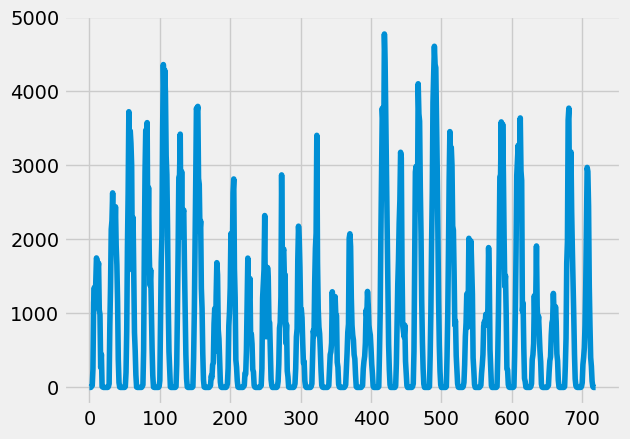

In [ ]:
plt.plot(y_pred['a'])

In [ ]:
# result_A = unnorm_df(result_A, means[0][1], stds[0][1])
# result_B = unnorm_df(result_B, means[1][1], stds[1][1])
# result_C = unnorm_df(result_C, means[2][1], stds[2][1])

In [ ]:
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
test_copy = test.copy() 

In [ ]:
id = range(2160)

In [ ]:
nom_fichier = 'XGBoost_prediction_by_hours_noise'
repertoire = ""
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
submission = pd.DataFrame({'id': id, 'prediction': result})

test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)